<a href="https://colab.research.google.com/github/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/notebooks/Week_4/Week_4_Lecture_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 5: Gradient Descent and Variants Part 1 <sup><mark style="background-color:gold">Code</mark> </sup>

In [42]:
#@title 
from ipywidgets import widgets
out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"UkEThLiReTY", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)
display(out1)

Output()

In [43]:
#@title 
from IPython import display as IPyDisplay
IPyDisplay.HTML(
    f"""
  <div>
    <a href= "https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Slides/Week_4/DL4CV_Week04_Part03.pdf" target="_blank">
    <img src="https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Data/Slides_Logo.png?raw=1"
  alt="button link to Airtable" style="width:200px"></a>
    </div>""" )

**Imports**

In [44]:
import matplotlib.pyplot as plt
import numpy as np

import time
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

## Training an MLP for image classification

Many of the core ideas (and tricks) in modern optimization for deep learning can be illustrated in the simple setting of training an MLP to solve an image classification task. 


$^\dagger$: A **strictly convex** function has the same global and local minimum - a nice property for optimization as it won't get stuck in a local minimum that isn't a global one (e.g., $f(x)=x^2 + 2x + 1$). A **non-convex** function is wavy - has some 'valleys' (local minima) that aren't as deep as the overall deepest 'valley' (global minimum). Thus, the optimization algorithms can get stuck in the local minimum, and it can be hard to tell when this happens (e.g., $f(x) = x^4 + x^3 - 2x^2 - 2x$).

### Data

We will use the MNIST dataset of handwritten digits. We load the data via the Pytorch `datasets` module



In [45]:
def load_mnist_data(change_tensors=False, download=False):
  """
  Load training and test examples for the MNIST handwritten digits dataset
  with every image: 28*28 x 1 channel (greyscale image)

  Args:
    change_tensors: Bool
      Argument to check if tensors need to be normalised
    download: Bool
      Argument to check if dataset needs to be downloaded/already exists

  Returns:
    train_set:
      train_data: Tensor
        training input tensor of size (train_size x 784)
      train_target: Tensor
        training 0-9 integer label tensor of size (train_size)
    test_set:
      test_data: Tensor
        test input tensor of size (test_size x 784)
      test_target: Tensor
        training 0-9 integer label tensor of size (test_size)
  """
  # Load train and test sets
  train_set = torchvision.datasets.MNIST(root='.', train=True, download=download,
                             transform=torchvision.transforms.ToTensor())
  test_set = torchvision.datasets.MNIST(root='.', train=False, download=download,
                            transform=torchvision.transforms.ToTensor())

  # Original data is in range [0, 255]. We normalize the data wrt its mean and std_dev.
  # Note that we only used *training set* information to compute mean and std
  mean = train_set.data.float().mean()
  std = train_set.data.float().std()

  if change_tensors:
    # Apply normalization directly to the tensors containing the dataset
    train_set.data = (train_set.data.float() - mean) / std
    test_set.data = (test_set.data.float() - mean) / std
  else:
    tform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean=[mean / 255.], std=[std / 255.])
                                            ])
    train_set = torchvision.datasets.MNIST.MNIST(root='.', train=True, download=download,
                               transform=tform)
    test_set = torchvision.datasets.MNIST.MNIST(root='.', train=False, download=download,
                              transform=tform)

  return train_set, test_set


train_set, test_set = load_mnist_data(change_tensors=True,download=True)

As we are just getting started, we will concentrate on a small subset of only 500 examples out of the 60.000 data points contained in the whole training set.


In [46]:
# Sample a random subset of 500 indices
subset_index = np.random.choice(len(train_set.data), 500)

# We will use these symbols to represent the training data and labels, to stay
# as close to the mathematical expressions as possible.
X, y = train_set.data[subset_index, :], train_set.targets[subset_index]

Run the following cell to visualize the content of three examples in our training set. Note how the preprocessing we applied to the data changes the range of pixel values after normalization.

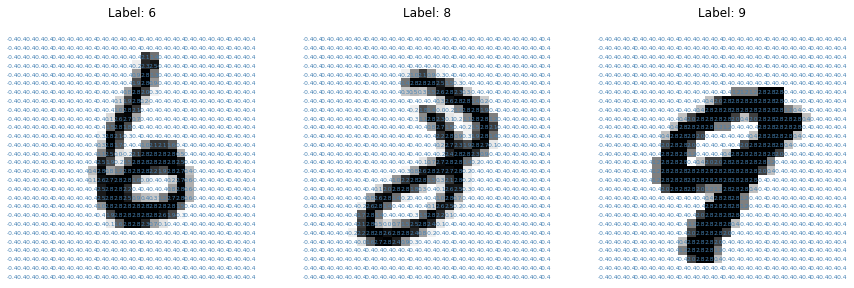

In [47]:
num_figures = 3
fig, axs = plt.subplots(1, num_figures, figsize=(5 * num_figures, 5))

for sample_id, ax in enumerate(axs):
  # Plot the pixel values for each image
  ax.matshow(X[sample_id, :], cmap='gray_r')
  # 'Write' the pixel value in the corresponding location
  for (i, j), z in np.ndenumerate(X[sample_id, :]):
    text = '{:.1f}'.format(z)
    ax.text(j, i, text, ha='center',
            va='center', fontsize=6, c='steelblue')

  ax.set_title('Label: ' + str(y[sample_id].item()))
  ax.axis('off')

plt.show()

### Model



As you will see next week, there are specific model architectures that are better suited to image-like data, such as Convolutional Neural Networks (CNNs). For simplicity, we will focus exclusively on Multi-Layer Perceptron (MLP) models as they allow us to highlight many important optimization challenges shared with more advanced neural network designs.

In [48]:
class MLP(nn.Module):
  """
  This class implements MLPs in Pytorch of an arbitrary number of hidden
  layers of potentially different sizes. Since we concentrate on classification
  tasks in this tutorial, we have a log_softmax layer at prediction time.
  """

  def __init__(self, in_dim=784, out_dim=10, hidden_dims=[], use_bias=True):
    """
    Constructs a MultiLayerPerceptron

    Args:
      in_dim: Integer
        dimensionality of input data (784)
      out_dim: Integer
        number of classes (10)
      hidden_dims: List
        containing the dimensions of the hidden layers,
        empty list corresponds to a linear model (in_dim, out_dim)

    Returns:
      Nothing
    """

    super(MLP, self).__init__()

    self.in_dim = in_dim
    self.out_dim = out_dim

    # If we have no hidden layer, just initialize a linear model (e.g. in logistic regression)
    if len(hidden_dims) == 0:
      layers = [nn.Linear(in_dim, out_dim, bias=use_bias)]
    else:
      # 'Actual' MLP with dimensions in_dim - num_hidden_layers*[hidden_dim] - out_dim
      layers = [nn.Linear(in_dim, hidden_dims[0], bias=use_bias), nn.ReLU()]

      # Loop until before the last layer
      for i, hidden_dim in enumerate(hidden_dims[:-1]):
        layers += [nn.Linear(hidden_dim, hidden_dims[i + 1], bias=use_bias),
                   nn.ReLU()]

      # Add final layer to the number of classes
      layers += [nn.Linear(hidden_dims[-1], out_dim, bias=use_bias)]

    self.main = nn.Sequential(*layers)

  def forward(self, x):
    """
    Defines the network structure and flow from input to output

    Args:
      x: Tensor
        Image to be processed by the network

    Returns:
      output: Tensor
        same dimension and shape as the input with probabilistic values in the range [0, 1]

    """
    # Flatten each images into a 'vector'
    transformed_x = x.view(-1, self.in_dim)
    hidden_output = self.main(transformed_x)
    output = F.log_softmax(hidden_output, dim=1)
    return output

Linear models constitute a very special kind of MLPs: they are equivalent to an MLP with *zero* hidden layers. This is simply an affine transformation, in other words a 'linear' map $W x$ with an 'offset' $b$; followed by a softmax function.

$$f(x) = \text{softmax}(W x + b)$$

Here $x \in \mathbb{R}^{784}$, $W \in \mathbb{R}^{10 \times 784}$ and $b \in \mathbb{R}^{10}$. Notice that the dimensions of the weight matrix are $10 \times 784$ as the input tensors are flattened images, i.e., $28 \times 28 = 784$-dimensional tensors and the output layer consists of $10$ nodes. Also, note that the implementation of softmax encapsulates b in W i.e., It maps the rows of the input instead of the columns. That is, the i’th row of the output is the mapping of the i’th row of the input under W, plus the bias term. Refer Affine maps here: https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#affine-maps

In [49]:
# Empty hidden_dims means we take a model with zero hidden layers.
model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

# We print the model structure with 784 inputs and 10 outputs
print(model)

MLP(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


### Loss


While we care about the accuracy of the model, the 'discrete' nature of the 0-1 loss makes it challenging to optimize. In order to learn good parameters for this model, we will use the cross entropy loss (negative log-likelihood), which you saw in the last lecture, as a surrogate objective to be minimized. 

This particular choice of model and optimization objective leads to a *convex* optimization problem with respect to the parameters $W$ and $b$. 

In [50]:
loss_fn = F.nll_loss

### Implement gradient descent

In [51]:
def zero_grad(params):
  """
  Clear gradients as they accumulate on successive backward calls

  Args:
    params: an iterator over tensors
      i.e., updating the Weights and biases

  Returns:
    Nothing
  """
  for par in params:
    if not(par.grad is None):
      par.grad.data.zero_()

In [52]:
def gradient_update(loss, params, lr=1e-3):
  """
  Perform a gradient descent update on a given loss over a collection of parameters

  Args:
    loss: Tensor
      A scalar tensor containing the loss through which the gradient will be computed
    params: List of iterables
      Collection of parameters with respect to which we compute gradients
    lr: Float
      Scalar specifying the learning rate or step-size for the update

  Returns:
    Nothing
  """
  # Clear up gradients as Pytorch automatically accumulates gradients from
  # successive backward calls
  zero_grad(params)

  # Compute gradients on given objective
  loss.backward()

  with torch.no_grad():
    for par in params:
      # Here we work with the 'data' attribute of the parameter rather than the
      # parameter itself.
      # Hence - use the learning rate and the parameter's .grad.data attribute to perform an update
      par.data -= lr * par.grad.data



model1 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print('\n The model1 parameters before the update are: \n')
for name, param in model1.named_parameters():
    if param.requires_grad:
      print(name, param.data)
loss = loss_fn(model1(X), y)

gradient_update(loss, list(model1.parameters()), lr=1e-1)
print('\n The model1 parameters after the update are: \n')
for name, param in model1.named_parameters():
    if param.requires_grad:
      print(name, param.data)


 The model1 parameters before the update are: 

main.0.weight tensor([[-0.0235, -0.0053,  0.0340,  ..., -0.0251,  0.0024,  0.0255],
        [ 0.0287, -0.0327,  0.0339,  ..., -0.0102,  0.0348, -0.0116],
        [ 0.0259, -0.0116, -0.0356,  ...,  0.0127, -0.0338,  0.0271],
        ...,
        [-0.0255,  0.0098, -0.0007,  ..., -0.0318,  0.0356,  0.0281],
        [ 0.0189, -0.0242,  0.0071,  ...,  0.0179, -0.0304, -0.0300],
        [ 0.0224, -0.0154,  0.0013,  ..., -0.0228, -0.0316,  0.0087]])
main.0.bias tensor([-0.0212, -0.0298,  0.0180,  0.0027,  0.0151,  0.0104, -0.0227, -0.0009,
         0.0277,  0.0013])

 The model1 parameters after the update are: 

main.0.weight tensor([[-0.0228, -0.0047,  0.0347,  ..., -0.0244,  0.0031,  0.0262],
        [ 0.0267, -0.0348,  0.0319,  ..., -0.0123,  0.0327, -0.0137],
        [ 0.0266, -0.0109, -0.0349,  ...,  0.0134, -0.0331,  0.0278],
        ...,
        [-0.0264,  0.0089, -0.0016,  ..., -0.0326,  0.0347,  0.0273],
        [ 0.0201, -0.0230,  0

**Acknowledgements**

Code adopted from the Deep Learning Summer School offered by Neuromatch Academy

https://deeplearning.neuromatch.io/tutorials/intro.html